In [83]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.layers import Activation, Dense, Dropout

from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from sklearn.model_selection import train_test_split

In [84]:
data = pd.read_excel(r"C:\Users\ASUS\Downloads\Finance Distress.xlsx",index_col=0)

In [85]:
data.head()

,EBIT_on_TotalAssets,WorkingCapital_on_TotalAssets,ROA,Debt_to_TotalAssets,CurrentRatio,FirmSize,MarketValue_on_BookValue,ReturnEarnings_on_TotalAssets,TotalAssets_Turnover,Z-Score95
Ticker,,,,,,,,,,
AAA,0.038204,0.431383,0.020744,0.580775,1.606347,6.291094,0.549380,0.061048,0.825956,0
AAA,0.062997,0.332126,0.046440,0.689775,1.194128,6.488214,0.338109,-0.001584,0.696568,0
AAA,0.089299,0.342995,0.057551,0.644905,1.076307,6.660501,0.356928,0.004593,0.889307,0
AAA,0.050466,0.435064,0.028177,0.604173,1.244305,6.876747,0.474205,0.037358,1.064072,0
AAA,0.103013,0.517662,0.061475,0.592456,1.535962,6.902408,0.455837,-0.015609,1.159077,0


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3030 entries, AAA to WCS
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   EBIT_on_TotalAssets            3030 non-null   float64
 1   WorkingCapital_on_TotalAssets  3030 non-null   float64
 2   ROA                            3030 non-null   float64
 3   Debt_to_TotalAssets            3030 non-null   float64
 4   CurrentRatio                   3030 non-null   float64
 5   FirmSize                       3030 non-null   float64
 6   MarketValue_on_BookValue       3030 non-null   float64
 7   ReturnEarnings_on_TotalAssets  3030 non-null   float64
 8   TotalAssets_Turnover           3030 non-null   float64
 9   Z-Score95                      3030 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 260.4+ KB


In [87]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=n_state)

In [88]:
df = data.copy()

In [89]:
# Set the independent variable property
feature = df.columns[df.columns!='Z-Score95'].to_list()
target = [df.columns[-1]]

y = df[target]
X = df[feature]

# Split the train and test
n_state = 42
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7,random_state=n_state)

In [90]:
# smoth_X, smoth_y = os.fit_resample(X_train,y_train)
# X_train = pd.DataFrame(smoth_X,columns=feature)
# y_train = pd.DataFrame(smoth_y,columns=target)


In [91]:
# Call scale function
sc_X = StandardScaler()
# Scale train set
X_train = sc_X.fit_transform(X_train)
# Scale test set
X_test = sc_X.fit_transform(X_test)

In [92]:
LR_classifier = LogisticRegression()
LR_classifier.fit(X_train, y_train)

y_pred = LR_classifier.predict(X_test)
y_pred = pd.DataFrame(y_pred,index=y_test.index,columns=['Logistic Regression Prediction'])

# Ma trận bối rối
print(f'Confusion Matrix:\n{pd.DataFrame(confusion_matrix(y_test,y_pred))}\n')

# Báo cáo phân loại
print(f'Report model:\n{classification_report(y_test,y_pred)}')

# Tỉ lệ chính xác accuracy
print('Logistic Regression accuracy without using stock market news headline: ', round(accuracy_score(y_test, y_pred),4))

Confusion Matrix:
     0   1
0  867   1
1    6  35

Report model:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       868
           1       0.97      0.85      0.91        41

    accuracy                           0.99       909
   macro avg       0.98      0.93      0.95       909
weighted avg       0.99      0.99      0.99       909

Logistic Regression accuracy without using stock market news headline:  0.9923


In [93]:
import statsmodels.api as SM 
table = SM.Logit(y_train,X_train).fit()
print(table.summary())

Optimization terminated successfully.
         Current function value: 0.675632
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              Z-Score95   No. Observations:                 2121
Model:                          Logit   Df Residuals:                     2112
Method:                           MLE   Df Model:                            8
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:                  -2.754
Time:                        16:10:32   Log-Likelihood:                -1433.0
converged:                       True   LL-Null:                       -381.75
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3030      0.288      1.053      0.292      -0.261       0.867
x2            -0.3381      0.

In [94]:
# Xây dựng mô hình Random Forest
RF_classifier = RandomForestClassifier(random_state=n_state,
                                        n_estimators=500, 
                                        # min_samples_leaf = 4,
                                        # max_depth = 25,
                                        criterion="log_loss")
                                        # min_samples_split=4)


RF_classifier.fit(X_train, y_train)

# Dự báo giá trị biến phụ thuộc
y_pred = RF_classifier.predict(X_test)
y_pred = pd.DataFrame(y_pred,index=y_test.index,columns=['Random Forest Prediction'])

# Ma trận bối rối
print(f'Confusion Matrix:\n{pd.DataFrame(confusion_matrix(y_test,y_pred))}\n')

# Báo cáo phân loại
print(f'Report model:\n{classification_report(y_test,y_pred)}')

# Tỉ lệ chính xác accuracy
print('Random Forest accuracy without using stock market news headline: ', round(accuracy_score(y_test, y_pred),4))

Confusion Matrix:
     0   1
0  863   5
1    8  33

Report model:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       868
           1       0.87      0.80      0.84        41

    accuracy                           0.99       909
   macro avg       0.93      0.90      0.91       909
weighted avg       0.99      0.99      0.99       909

Random Forest accuracy without using stock market news headline:  0.9857


In [95]:
# train CatBoost model
model = CatBoostClassifier(iterations=100, learning_rate=0.05, loss_function='Logloss',depth=8)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 0.6529655	test: 0.6543670	best: 0.6543670 (0)	total: 11.4ms	remaining: 1.13s
1:	learn: 0.6179728	test: 0.6205607	best: 0.6205607 (1)	total: 20.1ms	remaining: 986ms
2:	learn: 0.5862392	test: 0.5935998	best: 0.5935998 (2)	total: 32.8ms	remaining: 1.06s
3:	learn: 0.5562680	test: 0.5640303	best: 0.5640303 (3)	total: 47.3ms	remaining: 1.14s
4:	learn: 0.5273535	test: 0.5349742	best: 0.5349742 (4)	total: 58.5ms	remaining: 1.11s
5:	learn: 0.5019174	test: 0.5120733	best: 0.5120733 (5)	total: 73.1ms	remaining: 1.15s
6:	learn: 0.4784914	test: 0.4916829	best: 0.4916829 (6)	total: 87.4ms	remaining: 1.16s
7:	learn: 0.4552846	test: 0.4682140	best: 0.4682140 (7)	total: 99.8ms	remaining: 1.15s
8:	learn: 0.4334115	test: 0.4476087	best: 0.4476087 (8)	total: 128ms	remaining: 1.29s
9:	learn: 0.4121043	test: 0.4263430	best: 0.4263430 (9)	total: 216ms	remaining: 1.94s
10:	learn: 0.3952215	test: 0.4107122	best: 0.4107122 (10)	total: 282ms	remaining: 2.28s
11:	learn: 0.3790630	test: 0.3945456	best: 0

In [96]:
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=["predictions"],index=y_test.index)

# evaluate model
train_score = model.score(X_train, y_train)
print('Train accuracy:', train_score)

test_score = model.score(X_test, y_test)
print('Test accuracy:', test_score)

Train accuracy: 0.9952852428099953
Test accuracy: 0.9867986798679867


In [97]:
# Ma trận bối rối
print(f'Confusion Matrix:\n{pd.DataFrame(confusion_matrix(y_test,y_pred))}\n')

# Báo cáo phân loại
print(f'Report model:\n{classification_report(y_test,y_pred)}')

# Tỉ lệ chính xác accuracy
print('Catboost model accuracy:', round(accuracy_score(y_test, y_pred),4))

Confusion Matrix:
     0   1
0  863   5
1    7  34

Report model:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       868
           1       0.87      0.83      0.85        41

    accuracy                           0.99       909
   macro avg       0.93      0.91      0.92       909
weighted avg       0.99      0.99      0.99       909

Catboost model accuracy: 0.9868


In [98]:
classifier_svm = SVC(kernel = 'linear', probability=True, random_state = n_state)
classifier_svm.fit(X_train, y_train)

y_pred = classifier_svm.predict(X_test)

y_pred = pd.DataFrame(y_pred,columns=["predictions"])

print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(y_test,y_pred)),'\n')

print('Classification report:')
print(classification_report(y_test,y_pred))

print('Support Vector Machine "Linear Kernel" accuracy without using stock market news headline:', round(accuracy_score(y_test, y_pred),4))

Confusion matrix:
     0   1
0  867   1
1    3  38 

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       868
           1       0.97      0.93      0.95        41

    accuracy                           1.00       909
   macro avg       0.99      0.96      0.97       909
weighted avg       1.00      1.00      1.00       909

Support Vector Machine "Linear Kernel" accuracy without using stock market news headline: 0.9956


In [99]:
import shap
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

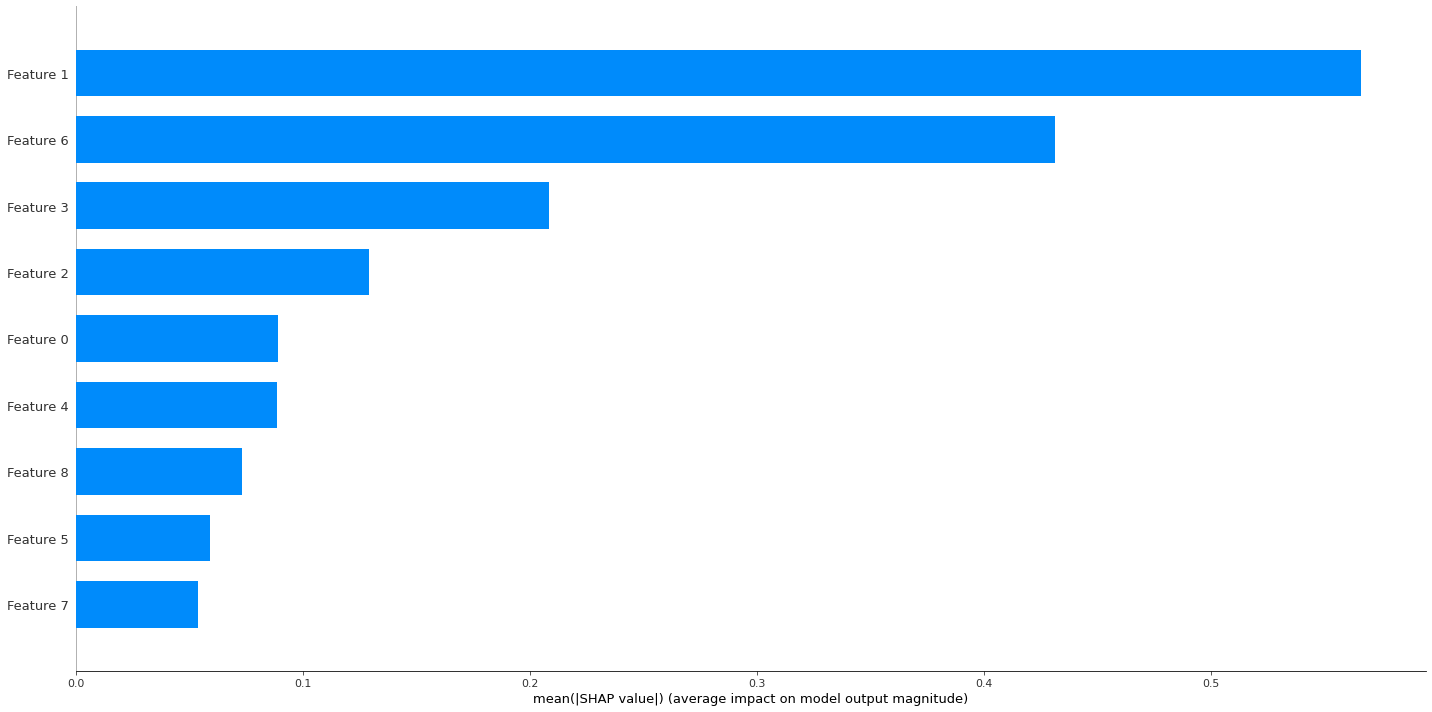

In [100]:
# Bar chart
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False,plot_size = [20,10])

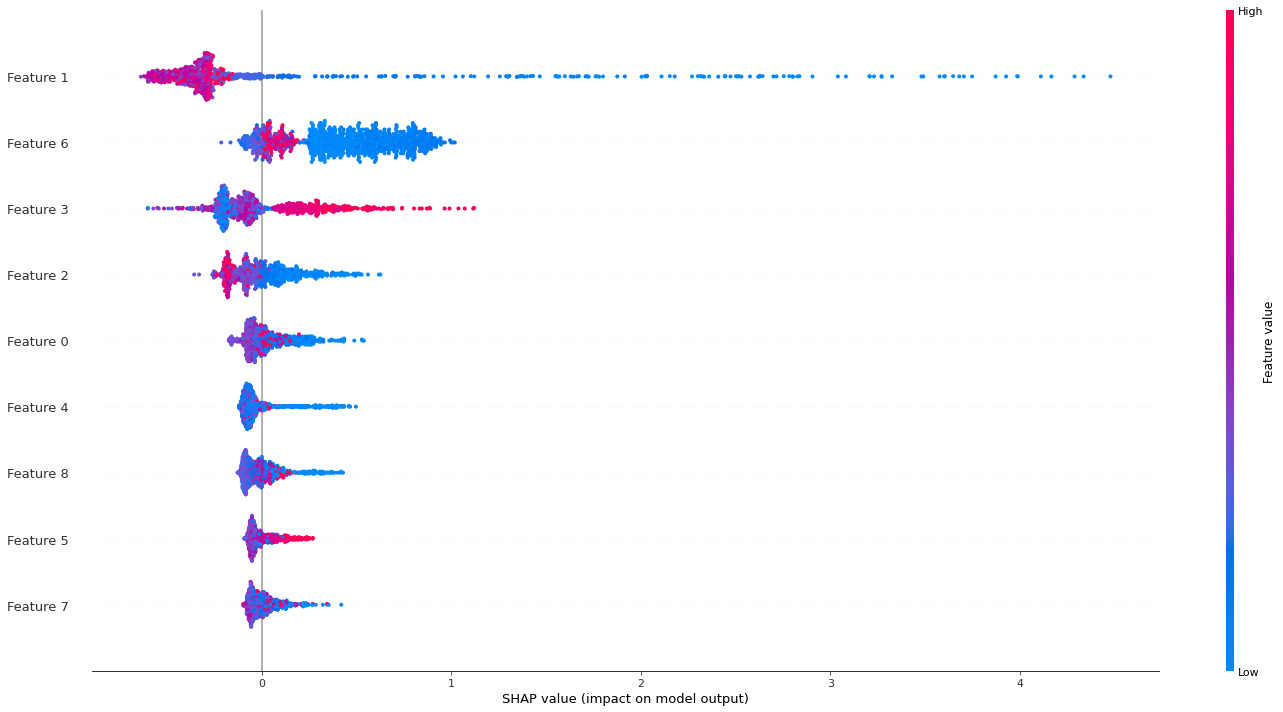

In [101]:
# a density scatter plot
shap.summary_plot(shap_values, X_test,plot_size = [20,10])


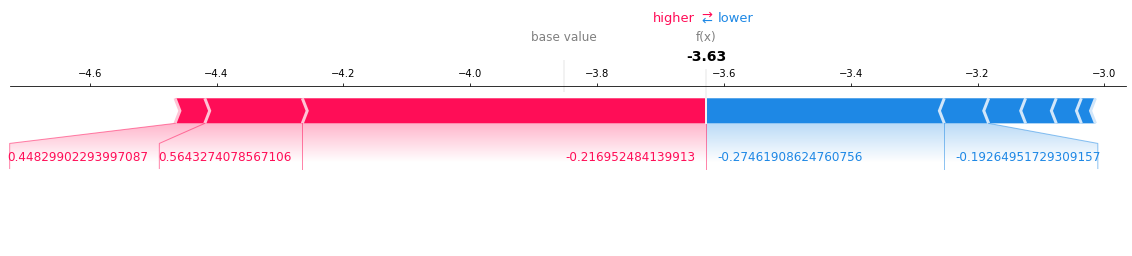

In [102]:
# load Javascript library for visualization in notebook
shap.initjs()

# plot and save the image for the report
def shap_indiv_plot(m):
 return shap.force_plot(explainer.expected_value, shap_values[m], X_test[m],show=False,matplotlib=True).savefig('Shap_plot_03.png', bbox_inches='tight')

# plot the Shap values for the 9th data point/borrower in the dataset, for example
shap_indiv_plot(9)